# Deterministic quantum computing with one quantum bit

Deterministic quantum computing with one quantum bit (DQC1) is a model of mixed state quantum computation introduced by Knill and Laflamme in 1998 [1]. For an auxiliary register (a.k.a. bath) initially in the maximally mixed state, it returns the normalized trace of a controlled unitary acting on the bath from measurements of a single qubit (acting as the control), with an accuracy independent of the problem size. There is no known polynomial-time classical algorithm for estimating the normalized trace, and indeed, a recent paper by Fuuji et al. proved that the output distribution of DQC1 cannot be classically sampled unless the so-called polynomial hierarchy collapses to the second level [2], a possibility deemed so preposterous it was lampooned in a blog post by well-known computer scientist Scott Aaronson [3]. Notably, in the case where the control qubit starts in a pure state (e.g. $|0\rangle$), it does this without generating any entanglement between the control qubit and the bath [4]. This led Ollivier and Zurek [5] and Henderson and Vedral [6] to propose quantum discord as an alternate measure of non-classical resources.

In [1]:
from math import pi, sqrt

In [13]:
import numpy as np

# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile, Aer, IBMQ, execute
from qiskit.circuit import Gate, ControlledGate
from qiskit.extensions.unitary import UnitaryGate
from qiskit.providers.aer.library import SetDensityMatrix
from qiskit.quantum_info import *
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from ibm_quantum_widgets import *
from qiskit.providers.aer import QasmSimulator

# Loading your IBM Quantum account(s)
provider = IBMQ.load_account()

ibmqfactory.load_account:WARNING:2021-10-17 14:48:57,225: Credentials are already in use. The existing account in the session will be replaced.


# Picking a unitary whose trace we want to evaluate

First, we generate a unitary matrix of size $2^N$, where $N$ is the number of bath qubits. We then realize it as a controlled `UnitaryGate`.

In [24]:
N = 2

unitary = random_unitary(2**N)
print("Trace:", np.trace(unitary))

controlled_unitary = UnitaryGate(Operator(unitary), label='U').control(1)

Trace: (0.4327798523524718+0.5395980939716478j)


# Setting up the initial state

The bath is initialized in the maximally mixed state, while the control qubit is left in the $|0\rangle$ state.

In [25]:
initial_control_state = DensityMatrix(Statevector([1,0]))
initial_bath_state = DensityMatrix(np.eye(2**N))/2**N
initial_state = initial_bath_state.tensor(initial_control_state)

We can verify we've done this correctly by tracing out the control qubit:

In [26]:
print(partial_trace(initial_bath_state.tensor(initial_control_state),[0]))

DensityMatrix([[0.25+0.j, 0.  +0.j, 0.  +0.j, 0.  +0.j],
               [0.  +0.j, 0.25+0.j, 0.  +0.j, 0.  +0.j],
               [0.  +0.j, 0.  +0.j, 0.25+0.j, 0.  +0.j],
               [0.  +0.j, 0.  +0.j, 0.  +0.j, 0.25+0.j]],
              dims=(2, 2))


# Building the circuit for measuring $\mathrm{Tr}\{U\}$

The DQC1 circuit is drawn below. To learn about the real (imaginary) part of the trace of $U$, we measure the control qubit in the X-basis (Y-basis):

$$\langle Z\rangle=\frac{1}{2^N}\mathrm{Re}\:\mathrm{Tr}\{U\}.$$



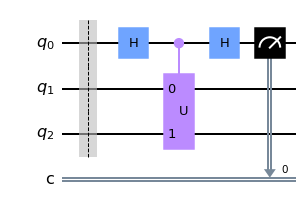

In [27]:
qc = QuantumCircuit(N+1,1)
qc.set_density_matrix(initial_state)
qc.h(0)
qc.append(controlled_unitary, range(N+1)) 
qc.h(0)
qc.measure(0, 0)
  
qc.draw(output='mpl')

This circuit is implemented in the following function, which runs the experiment `num_shots` times in order to build statistics for $\langle Z\rangle$. With `Y_basis==True`, the measurement is performed in the Y-basis.

In [31]:
backend = Aer.get_backend('qasm_simulator')

def measure_Z(unitary, Y_basis=False):
    
    #Let's start by defining our initial state:
    N=int(np.log(unitary.dim[0])/np.log(2))
    initial_control_state = DensityMatrix(Statevector([1,0]))
    initial_bath_state = DensityMatrix(np.eye(2**N))/2**N
    initial_state = initial_bath_state.tensor(initial_control_state)
    
    #We set up the circuit exactly as above, but we now account for the possibility of measuring in the Y-basis.     
    qc = QuantumCircuit(N+1,1)
    qc.set_density_matrix(initial_state)
    qc.h(0)
    qc.append(controlled_unitary, range(N+1))
    if Y_basis == True:
        qc.sdg(0)
    qc.h(0)
    qc.measure(0, 0)
   
    #The accuracy of our estimate is ~1/sqrt(num_shots), independent of N. To get an accuracy on the order of 0.01,
    #we take num_shots = 10000:
    num_shots = 10000
    result = execute(qc, backend, shots=num_shots).result()
    counts = result.get_counts()
    
    #To calculate <Z>, we use the fact that <Z>=P(0)-P(1), where P(0) designates the probability of measuring 0.
    num_zeros = counts['0']
    num_ones = counts['1']

    Z = (num_zeros-num_ones)/num_shots

    return Z

From our measurements in the X- and Y-bases, we recover $\mathrm{Tr}\{U\}$ by adding the real and imaginary parts appropriately (and multiplying by $2^N$ to account for the normalization):

In [32]:
def get_trace(unitary):
    N=np.log(unitary.dim[0])/np.log(2) 
    real_part = 2**N * measure_Z(unitary)
    im_part = 2**N * measure_Z(unitary, True)
    trace = real_part + im_part*1j
    return trace

Finally, we compare the actual trace of the matrix $U$ with the trace obtained from DQC1. Note that the accuracy of our estimate is ~1/sqrt(num_shots), independent of N.

In [34]:
actual_trace = np.trace(unitary)
DQC1_trace = get_trace(unitary)

print('Actual trace:', actual_trace)
print('Trace returned from DQC1:', DQC1_trace)

Actual trace: (0.4327798523524718+0.5395980939716478j)
Trace returned from DQC1: (0.4128+0.5584j)


[1] E. Knill and R. Laflamme, Phys. Rev. Lett. 81, 25 (1998).<br>
[2] K. Fujii, H. Kobayashi, T. Morimae, H Nishimura, S. Tamate, and S Tani, Phys. Rev. Lett. 120, 200502 (2018).<br>
[3] https://www.scottaaronson.com/writings/phcollapse.pdf<br>
[4] A. Datta, A. Shaji, and C. Caves, Phys. Rev. Lett. 100, 050502 (2008).<br>
[5] H. Ollivier and W.H. Zurek, Phys. Rev. Lett. 88, 017901 (2002).<br>
[6] L. Henderson and V. Vedral, J. Phys. A 34, 6899 (2001).